In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sqlite3 as sql
import os
import pandas as pd
from datetime import datetime
from glob import glob
import sklearn as sk
import sklearn.linear_model

os.sys.path.append('../')
import PlaceCellAnalysis as pc
import utilities as u
import preprocessing as pp
import behavior as b
import BayesianDecoding as bd
# import SplineEncodingModel.LinearRegressionSpline as lrsp
import EmpiricalDensityDecoding.SplineEncoding as edse



%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# load session
mouse = '4139265.3'
df = pp.load_session_db()


#df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])

df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout') | df_mouse['Track'].str.match('TwoTower_foraging')]
df_mouse

G:\My Drive\VR_Data\TwoTower\behavior.sqlite


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1403,4139265.3,10_02_2019,1,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.3\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...
1405,4139265.3,10_02_2019,3,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.3\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...
1433,4139265.3,12_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-12,G:\My Drive\VR_Data\TwoTower\4139265.3\12_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\12_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\12_02_2...
1455,4139265.3,15_02_2019,4,TwoTower_foraging,72,1,CA1,2019-02-15,G:\My Drive\VR_Data\TwoTower\4139265.3\15_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\15_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\15_02_2...
1475,4139265.3,17_02_2019,2,TwoTower_foraging,81,1,CA1,2019-02-17,G:\My Drive\VR_Data\TwoTower\4139265.3\17_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\17_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\17_02_2...
1495,4139265.3,19_02_2019,2,TwoTower_foraging,92,1,CA1,2019-02-19,G:\My Drive\VR_Data\TwoTower\4139265.3\19_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\19_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\19_02_2...
1513,4139265.3,21_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-21,G:\My Drive\VR_Data\TwoTower\4139265.3\21_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\21_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\21_02_2...
1522,4139265.3,22_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-22,G:\My Drive\VR_Data\TwoTower\4139265.3\22_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\22_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\22_02_2...
1531,4139265.3,23_02_2019,2,TwoTower_foraging,93,1,CA1,2019-02-23,G:\My Drive\VR_Data\TwoTower\4139265.3\23_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\23_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\23_02_2...
1537,4139265.3,24_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-24,G:\My Drive\VR_Data\TwoTower\4139265.3\24_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\24_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\24_02_2...


In [3]:
VRDat,C, S, A = pp.load_scan_sess(df_mouse.iloc[-3])
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


num aberrant ttls 0.0
38209 (38209,) (38209, 21) 126969


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


In [4]:
train_inds = (VRDat['pos']>0) & (VRDat['pos']<450) 
inds0 = (VRDat['morph']==0) & (VRDat['pos']>0)
inds1 = (VRDat['morph']==1) & (VRDat['pos']>0)

In [5]:
effMorph =VRDat.morph._values[train_inds]+VRDat.bckgndJitter._values[train_inds]+ VRDat.wallJitter._values[train_inds]
# print(np.amin(effMorph))
# effMorph = effMorph-np.amin(effMorph)
effMorph = (effMorph-np.amin(effMorph))/(np.amax(effMorph)-np.amin(effMorph)+.01)+.001

In [6]:
# print(np.amin(effMorph[train_inds]),np.amax(effMorph[train_inds]))
print(np.amin(effMorph),np.amax(effMorph))

0.001 0.9936029524043186


In [7]:
Cz = (C-np.amin(C,axis=0).reshape([1,-1]))/(np.amax(C,axis=0).reshape([1,-1])-np.amin(C,axis=0).reshape([1,-1])+1)*100. + .001
print(Cz.shape)

(38209, 1736)


In [8]:
nbd = edse.NBDecodingModel(Cz.shape[1])
nbd.fit_cells(VRDat.pos._values[train_inds],effMorph,Cz[train_inds,:])

(45, 5, 5, 1736)
[array([  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
       115., 125., 135., 145., 155., 165., 175., 185., 195., 205., 215.,
       225., 235., 245., 255., 265., 275., 285., 295., 305., 315., 325.,
       335., 345., 355., 365., 375., 385., 395., 405., 415., 425., 435.,
       445.]), array([0.1, 0.3, 0.5, 0.7, 0.9]), array([10., 30., 50., 70., 90.])]


In [9]:
L = nbd.get_likelihood(Cz[4000:8000,:])

99.99065 100.0 4 0
0
1000
2000
3000


In [10]:
print(L.shape)

(45, 5, 4000)


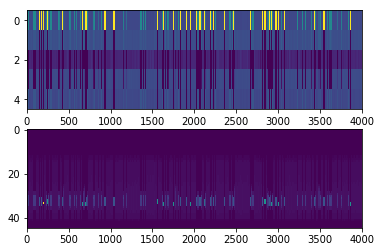

In [11]:
f,ax = plt.subplots(2,1)
ax[0].imshow(L.sum(axis=0),aspect='auto')
ax[1].imshow(L.sum(axis=1),aspect='auto')

NameError: name 'logJ' is not defined

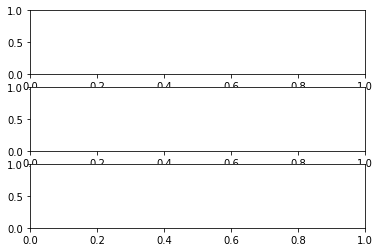

In [12]:
f,ax = plt.subplots(3,1)
ax[0].imshow(logJ,aspect = 'auto')#P_XM,aspect='auto')
ax[1].plot(P_XM.sum(axis=0).T)
# ax[1].plot(np.log(P_XM.sum(axis=0).T)/200)
ax[2].plot(P_XM.sum(axis=1))

pos_train = VRDat.pos._values[train_inds]
print(pos_train[1000],effMorph[1000])

In [13]:
J_cell = nbd._get_likelihood_1cell(Cz[train_inds,1000],1000)

0


AttributeError: 'NBDecodingModel' object has no attribute '_cells'

In [86]:
L = np.memmap("E:\\L.dat",dtype='float16',mode='r+',shape=(45,20,10,S.shape[1])) #,S.shape[0]))

In [78]:
P_XM = nbd.get_likelihood(Cz[1000:1100,:])

C:\Users\mplitt\MightyMorphingPhotonRangers\EmpiricalDensityDecoding\SplineEncoding.py:72: RuntimeWarning: divide by zero encountered in true_divide
  P_XM_t/=P_XM.ravel().sum()
C:\Users\mplitt\MightyMorphingPhotonRangers\EmpiricalDensityDecoding\SplineEncoding.py:72: RuntimeWarning: invalid value encountered in true_divide
  P_XM_t/=P_XM.ravel().sum()


KeyboardInterrupt: 

In [14]:
FEATS = np.zeros([train_inds.sum(),3])
FEATS[:,0],FEATS[:,1], FEATS[:,2] = VRDat.pos._values[train_inds],effMorph,Cz[train_inds,1000]
Count,edges = np.histogramdd(FEATS,bins=[45,10,10])
centers = []
for ed in edges:
    centers.append(ed[:-1]+ (ed[1:]-ed[:-1]).mean())

In [15]:
print(Count.ravel().sum())

30297.0


In [16]:
print(centers[0].shape,centers[1].shape,centers[2].shape)
print(edges)

(45,) (10,) (10,)
[array([2.80865305e-02, 1.00270410e+01, 2.00259954e+01, 3.00249498e+01,
       4.00239042e+01, 5.00228586e+01, 6.00218131e+01, 7.00207675e+01,
       8.00197219e+01, 9.00186763e+01, 1.00017631e+02, 1.10016585e+02,
       1.20015540e+02, 1.30014494e+02, 1.40013448e+02, 1.50012403e+02,
       1.60011357e+02, 1.70010312e+02, 1.80009266e+02, 1.90008221e+02,
       2.00007175e+02, 2.10006129e+02, 2.20005084e+02, 2.30004038e+02,
       2.40002993e+02, 2.50001947e+02, 2.60000901e+02, 2.69999856e+02,
       2.79998810e+02, 2.89997765e+02, 2.99996719e+02, 3.09995674e+02,
       3.19994628e+02, 3.29993582e+02, 3.39992537e+02, 3.49991491e+02,
       3.59990446e+02, 3.69989400e+02, 3.79988355e+02, 3.89987309e+02,
       3.99986263e+02, 4.09985218e+02, 4.19984172e+02, 4.29983127e+02,
       4.39982081e+02, 4.49981035e+02]), array([0.001     , 0.1002603 , 0.19952059, 0.29878089, 0.39804118,
       0.49730148, 0.59656177, 0.69582207, 0.79508236, 0.89434266,
       0.99360295]), arra

In [17]:
P,M,Z = np.meshgrid(centers[0],centers[1],centers[2],indexing='ij')

In [18]:
print(Count.shape,P.shape,M.shape,Z.shape)

(45, 10, 10) (45, 10, 10) (45, 10, 10) (45, 10, 10)


In [19]:
encmdl = edse.EncodingModel()
spl_basis = encmdl.make_design_matrix(P.ravel(),M.ravel(),Z.ravel())
print(spl_basis.shape)
encmdl.fit_linear(spl_basis,Count.ravel())
Count_hat = encmdl.predict_linear(spl_basis)

(4500, 125)


In [20]:
Count_hat = Count_hat.reshape([45,10,10])

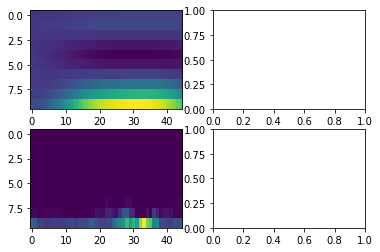

In [21]:
f,ax = plt.subplots(2,2)
ax[0,0].imshow(Count_hat[:,0,::-1].T,aspect = 'auto')
ax[1,0].imshow(Count[:,5,::-1].T,aspect='auto')

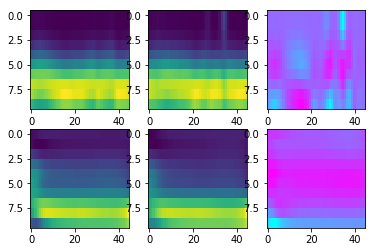

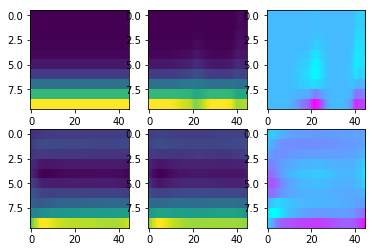

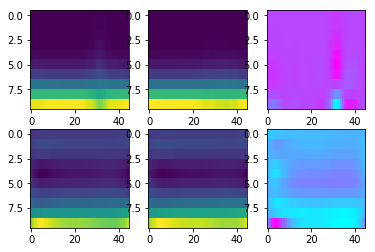

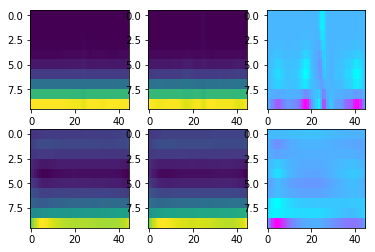

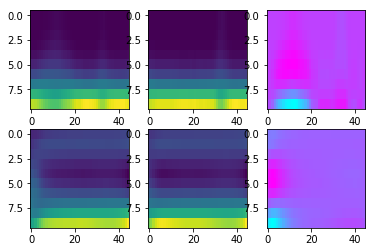

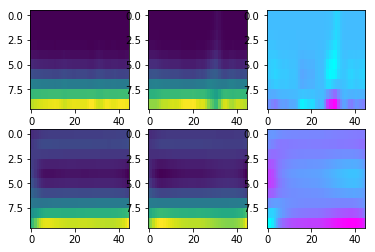

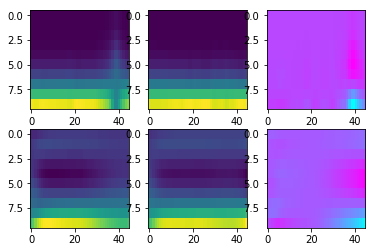

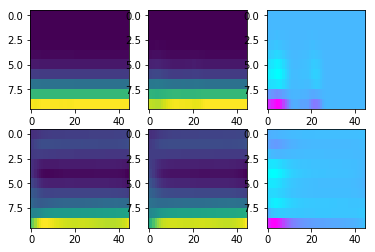

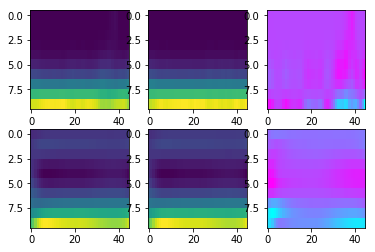

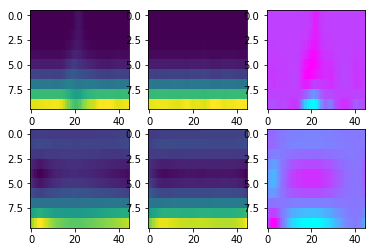

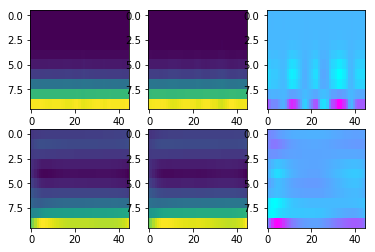

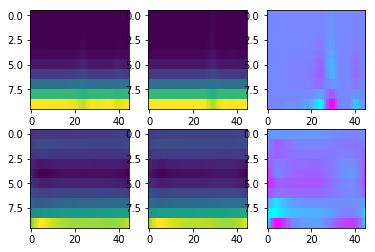

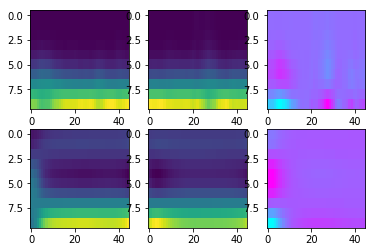

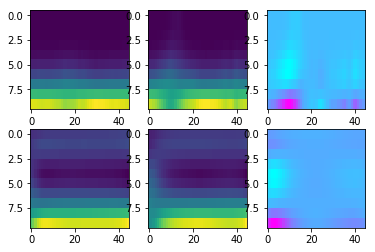

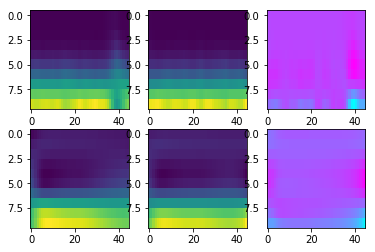

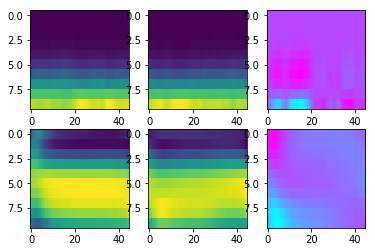

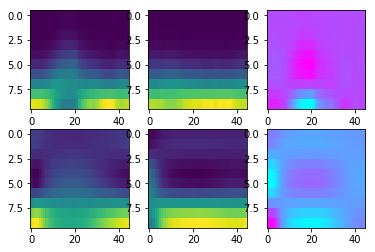

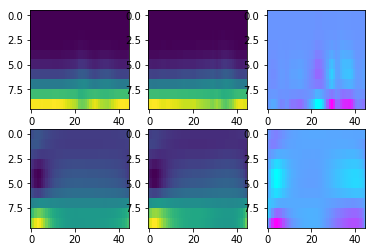

In [22]:
#cell = 118
x = np.linspace(0,450,num=45)
y = np.linspace(0,100,num = 10)
X,Y = np.meshgrid(x,y)
for c in range(0,Cz.shape[1],100):

    cell = c
    pdf0 = bd.empirical_density(VRDat['pos'].loc[inds0]._values,Cz[inds0,cell],ybins=np.arange(0,100,10))
    pdf1 = bd.empirical_density(VRDat['pos'].loc[inds1]._values,Cz[inds1,cell],ybins=np.arange(0,100,10))
    
    
    PXY0 = np.zeros([x.size,y.size])
    PXY1 = np.zeros([x.size,y.size])
    for i,xx in enumerate(x.tolist()):
        for j,yy in enumerate(y.tolist()):
            PXY0[i,j]=pdf0.Likelihood(xx,yy)
            PXY1[i,j]=pdf1.Likelihood(xx,yy)
    
   
    f,ax = plt.subplots(2,3)
    ax[0,0].imshow(PXY0.T[::-1,:],aspect='auto')
    ax[0,1].imshow(PXY1.T[::-1,:],aspect='auto')
    ax[0,2].imshow(PXY0.T[::-1,:]-PXY1.T[::-1,:],aspect='auto',cmap='cool')
   


    ###
    FEATS[:,2] = Cz[train_inds,c]
    Count,edges = np.histogramdd(FEATS,bins=[45,10,10])
    encmdl.fit_linear(spl_basis,Count.ravel())
    Count_hat = encmdl.predict_linear(spl_basis)
    Count_hat = Count_hat.reshape([45,10,10])
#     f,ax = plt.subplots(1,3)
    Ch_0 = np.squeeze(Count_hat[:,1,::-1].T)
#     print(Ch_0.shape)
    Ch_0/=Ch_0.sum(axis=0)[np.newaxis,:]
    Ch_1 = np.squeeze(Count_hat[:,-1,::-1].T)
    Ch_1/=Ch_1.sum(axis=0)[np.newaxis,:]
    ax[1,0].imshow(Ch_0,aspect = 'auto')
    ax[1,1].imshow(Ch_1,aspect='auto')
    ax[1,2].imshow(Ch_0-Ch_1,aspect='auto',cmap='cool')#,vmin=-.2,vmax=.2)
    

In [43]:
sp.stats.gamma(1,1)

In [50]:
x = np.linspace(0,450)
y = np.linspace(-3,15)
xx,yy = np.meshgrid(x,y)

In [51]:
print(xx.shape)

(50, 50)


In [151]:
C.shape[0]**(-1./6)

0.18365446328092436